In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [3]:
import torch

In [4]:
rcParams.update({'font.size': 16})

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
from Flow_Perturbation.src.GMM_distribution import get_energy_device,sample_NWell

In [7]:
nsamples = 20000
ndim = 50
nwell = 10
samples, Nwellinfo = sample_NWell(nsamples, ndim, nwell)
Nwellinfo[-1] = np.ones_like(Nwellinfo[-1])
X = samples
sig_data = 1.4
print('sig_data:',sig_data)

sig_data: 1.4


In [8]:
Nwellinfo = [torch.tensor(array, dtype=torch.float).to(device) for array in Nwellinfo]

In [9]:
ndim = X.shape[-1]

In [10]:
ndim

50

In [11]:
dataset = torch.Tensor(X).float().reshape((-1,ndim))

In [12]:
torch.std(dataset, dim=-1)

tensor([1.1760, 1.1766, 1.3921,  ..., 1.3929, 1.4551, 1.2528])

In [13]:
torch.std(dataset)

tensor(1.3141)

In [14]:
print(dataset.shape)

torch.Size([200000, 50])


In [15]:
device

device(type='cuda')

In [16]:
from Flow_Perturbation.src.common import MLP_nonorm, MLP_var
from Flow_Perturbation.src.EDM import loss_EDM
from Flow_Perturbation.src.train import train_model_EDM
model = MLP_nonorm(ndim=ndim,hidden_size=200,hidden_layers=2,emb_size=20).to(device)
batch_size = 128
dataset = dataset.to(device)
print(dataset.shape)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)
path = 'models/GMM50'
#model = train_model_EDM(model, device, ndim, sig_data, dataloader, path, num_epoch=101,lr=2e-4, loss_EDM = loss_EDM,decay_steps = 50)
#model.load_state_dict(torch.load(f'{path}/{ndim}-d-model.pth', map_location=device))
model = train_model_EDM(model , device, ndim, sig_data, dataloader, path, num_epoch=21,lr=2e-4, loss_EDM = loss_EDM,decay_steps = 20)
print('Training done!')
model.eval()

torch.Size([200000, 50])
Training model...
0.9388328987058736
0.8830800529328662
Training done!


MLP_nonorm(
  (time_mlp): PositionalEmbedding(
    (layer): SinusoidalEmbedding()
  )
  (joint_mlp): Sequential(
    (0): Linear(in_features=70, out_features=200, bias=True)
    (1): GELU(approximate='none')
    (2): Block_nonorm(
      (ff): Linear(in_features=200, out_features=200, bias=True)
      (act): GELU(approximate='none')
    )
    (3): Block_nonorm(
      (ff): Linear(in_features=200, out_features=200, bias=True)
      (act): GELU(approximate='none')
    )
    (4): Linear(in_features=200, out_features=50, bias=True)
  )
)

In [17]:
for param in model.parameters():
    param.requires_grad = False

In [18]:
from Flow_Perturbation.src.EDM import EMDSampler
Sampler = EMDSampler(model, sig_data , device)

exact_dynamics_heun = Sampler.exact_dynamics_heun
heun_torch = Sampler.heun_torch
score_function_rearange = Sampler.score_function_rearange
score_function_1element = Sampler.score_function_1element

In [19]:
sampN = 1000
tmax = 15.0
epsilon = 0.01
lambdaT = tmax**2
xT = np.sqrt(lambdaT) * torch.randn(sampN, ndim).to(device)

x0 = exact_dynamics_heun(epsilon, tmax, xT)
Y_init = x0.cpu().detach()

In [20]:
sampN = 1000
lambdaT = tmax**2
xT = np.sqrt(lambdaT) * torch.randn(sampN, ndim).to(device)

x0 = exact_dynamics_heun(epsilon, tmax, xT)
xTp = exact_dynamics_heun(tmax, epsilon, x0)

xT - xTp

tensor([[ 2.7657e-04, -2.1935e-04, -2.9945e-04,  ...,  5.1498e-05,
          9.2030e-05,  6.0081e-05],
        [ 2.0218e-04,  5.8413e-05,  2.0790e-04,  ...,  8.9645e-05,
          6.9737e-05, -1.9360e-04],
        [-1.2302e-04,  6.3419e-05, -1.2970e-04,  ..., -1.8978e-04,
         -4.8828e-04,  1.5926e-04],
        ...,
        [ 2.2316e-04, -1.6689e-05,  1.0443e-04,  ..., -1.3542e-04,
          1.9741e-04, -1.0014e-05],
        [-5.0306e-05,  1.6117e-04, -1.2493e-04,  ...,  2.8133e-05,
         -1.2493e-04, -4.3106e-04],
        [-1.2875e-04, -1.7166e-04, -2.3365e-05,  ..., -2.1935e-05,
          2.6226e-04,  1.8215e-04]], device='cuda:0')

In [21]:
energy_target =get_energy_device(dataset, Nwellinfo)

In [22]:
print(energy_target.mean())

tensor(66.3363, device='cuda:0')


In [23]:
print(get_energy_device(x0, Nwellinfo).mean())

tensor(69.4291, device='cuda:0')


In [24]:
sampN = 10000
lambdaT = tmax**2

xT = np.sqrt(lambdaT) * torch.randn(sampN, ndim).to(device)
eps = torch.randn_like(xT)

back_coeff = 0.001
x0 = exact_dynamics_heun(epsilon, tmax, xT) + back_coeff * eps # backward dynamics

dxT = xT - exact_dynamics_heun(tmax, epsilon, x0) # this is the error in xT that needs to be matched
eps_squarenorm = torch.sum(eps**2, dim=-1)

In [25]:
from Flow_Perturbation.src.train import CustomDataset, train_model_var
from torch.utils.data import DataLoader

In [26]:
batch_size = 128
dataset = CustomDataset(x0, dxT, eps_squarenorm)
dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True, drop_last=True)
# Create the model
model_var = MLP_var(ndim=ndim).to(device)
model_var = train_model_var(model_var, dataloader, back_coeff, num_epoch=301,lr=1e-3,path=path,decay_steps = 100)
model.eval()

0 4.342164568411998
4.342164568411998
1 3.407050294753833
2 3.2999058900735316
3 3.197039552223988
4 3.1444305028670874
5 3.058030993510515
6 3.060472775728275
7 3.054698549784147
8 3.0341319212546716
9 2.9543325228568835
10 2.9957299049084005
11 2.9307945233124952
12 2.907488566178542
13 2.8758404621711144
14 2.8916959090110583
15 2.8963017891614866
16 2.868209313123654
17 2.905618334427858
18 2.8985107097870264
19 2.841486340914017
20 2.8325574764838586
21 2.810646821291019
22 2.7780881569935727
23 2.7951535475559726
24 2.7728508710861206
25 2.731768085406377
26 2.7753524688573985
27 2.7760209150803394
28 2.737879212086017
29 2.696513661971459
30 2.6906408193783884
31 2.6653516598236866
32 2.644944499700497
33 2.6391607706363382
34 2.645933068715609
35 2.614315051298875
36 2.6491758976227198
37 2.635851639967698
38 2.600602110226949
39 2.5672341157228518
40 2.570443535462404
41 2.5912792346416373
42 2.5524257941123767
43 2.5183691458824353
44 2.5003600059411464
45 2.5112129083046546


MLP_nonorm(
  (time_mlp): PositionalEmbedding(
    (layer): SinusoidalEmbedding()
  )
  (joint_mlp): Sequential(
    (0): Linear(in_features=70, out_features=200, bias=True)
    (1): GELU(approximate='none')
    (2): Block_nonorm(
      (ff): Linear(in_features=200, out_features=200, bias=True)
      (act): GELU(approximate='none')
    )
    (3): Block_nonorm(
      (ff): Linear(in_features=200, out_features=200, bias=True)
      (act): GELU(approximate='none')
    )
    (4): Linear(in_features=200, out_features=50, bias=True)
  )
)

In [27]:
for param in model_var.parameters():
    param.requires_grad = False

In [28]:
def get_log_omega(xT, eps):
    x0 = exact_dynamics_heun(epsilon, tmax, xT) + back_coeff * eps
    # forward dynamics
    # xT = exact_dynamics_heun(tmax, 0, x0, mus0, covs0) + forw_coeff * eps_tilde
    forw_coeff = model_var(x0)
    eps_tilde = (xT - exact_dynamics_heun(tmax, epsilon, x0))/forw_coeff
    deltaSt = -0.5 * torch.sum(eps_tilde**2 - eps**2, dim=-1) - ndim * torch.log(forw_coeff).squeeze(-1) + ndim * np.log(back_coeff)
    uz = torch.sum(xT**2/tmax**2, dim=-1)/2.0  + 0.5*ndim*np.log(2*np.pi) + ndim*np.log(tmax)
    ux = get_energy_device(x0, Nwellinfo)
    log_omega = -ux + deltaSt + uz

    return log_omega, x0, ux

In [29]:
# generate starting point for the MCMC move
# we need xT_init, eps_init, log_omega_init
# do the backward-forward dynamics, get deltaSt, determine forward coeff
sampN = 1000

xT_init = np.sqrt(lambdaT) * torch.randn(sampN, ndim).to(device)
eps_init = torch.randn_like(xT_init)
log_omega_init, x0_init,ux_init = get_log_omega(xT_init, eps_init)

In [30]:
samples_selected = ux_init < 200

In [31]:
'''
xT = xT_init[samples_selected].clone()
eps = eps_init[samples_selected].clone()
x0 = x0_init[samples_selected].clone()
log_omega = log_omega_init[samples_selected].clone()
ux = ux_init[samples_selected].clone()
'''
xT = xT_init.clone()
eps = eps_init.clone()
x0 = x0_init.clone()
log_omega = log_omega_init.clone()
ux = ux_init.clone()
print(xT.shape)

torch.Size([1000, 50])


In [32]:
from Flow_Perturbation.src.MC import get_vjp_score_mnoise, get_vjp_score, run_mcmc_and_save, get_jacobian_score, v_jacobian_score_batch
from Flow_Perturbation.src.utils import generate_tsampling
v_jacobian_score = get_jacobian_score(score_function_1element)

In [33]:
K_x=5
K_eps=5

In [34]:
import os

In [35]:
if not os.path.exists('models/GMM50/data_GMM50'):
    os.makedirs('models/GMM50/data_GMM50')

In [36]:
nmcmc = 2000 # number of MCMC steps
concatenated_x0_last_steps = run_mcmc_and_save(nmcmc, ux, x0, xT, eps, log_omega , device, back_coeff,get_log_omega, 
                                                tmax=tmax, K_x=K_x, K_eps=K_eps, if_sava=False, if_eps=True,path='models/GMM50/data_GMM50/GMM50-FP',last_steps=50,count_last=10)

0 tensor(67.3329, device='cuda:0') tensor(587, device='cuda:0')
1 tensor(66.4785, device='cuda:0') tensor(511, device='cuda:0')
2 tensor(66.1277, device='cuda:0') tensor(474, device='cuda:0')
3 tensor(65.8202, device='cuda:0') tensor(468, device='cuda:0')
4 tensor(65.6227, device='cuda:0') tensor(439, device='cuda:0')
5 tensor(65.6336, device='cuda:0') tensor(442, device='cuda:0')
6 tensor(65.5359, device='cuda:0') tensor(399, device='cuda:0')
7 tensor(65.4908, device='cuda:0') tensor(405, device='cuda:0')
8 tensor(65.4143, device='cuda:0') tensor(395, device='cuda:0')
9 tensor(65.4001, device='cuda:0') tensor(373, device='cuda:0')
10 tensor(65.3968, device='cuda:0') tensor(382, device='cuda:0')
11 tensor(65.4026, device='cuda:0') tensor(380, device='cuda:0')
12 tensor(65.3084, device='cuda:0') tensor(346, device='cuda:0')
13 tensor(65.3182, device='cuda:0') tensor(349, device='cuda:0')
14 tensor(65.2091, device='cuda:0') tensor(347, device='cuda:0')
15 tensor(65.2354, device='cuda:0')

In [37]:
concatenated_x0_last_steps.shape

torch.Size([10000, 50])

In [38]:
Y_FP = concatenated_x0_last_steps.cpu().detach()

In [39]:
def exact_dynamics_heun_dSt_Huch(tn, tn1, xtn1): # do a lot of Heun steps between tn and tn1 to get the accurate xtn
    ts = generate_tsampling(tn, tn1, 100, 3)
    xt = xtn1 # set the initial x
    dSt = torch.zeros(xt.shape[0]).to(device) # this stores the sum of log(abs(J)) for each step
    
    eps = torch.randn_like(xt)
    _, div_xt = get_vjp_score(xt, ts[len(ts)-1], eps, score_function_rearange)
    #print(score_xt)
    for i in range(len(ts)-1, 0, -1):
        xt_new = heun_torch(ts[i-1], ts[i], xt)
        eps = torch.randn_like(xt_new)
        _, div_xt_new = get_vjp_score(xt_new, ts[i-1], eps, score_function_rearange)

        dSt += (ts[i-1]-ts[i])*(ts[i]*div_xt + ts[i-1]*div_xt_new)/2
        
        div_xt = div_xt_new
        xt = xt_new
    return xt, -dSt

 
def get_log_omega_J(xT, eps=None):
    x0, deltaSt = exact_dynamics_heun_dSt_Huch(epsilon, tmax, xT) 
    uz = torch.sum(xT**2/tmax**2, dim=-1)/2.0  + 0.5*ndim*np.log(2*np.pi) + ndim*np.log(tmax)
    ux = get_energy_device(x0, Nwellinfo)
    log_omega = -ux + deltaSt + uz

    return log_omega, x0, ux

In [40]:

sampN = 1000

xT_init = np.sqrt(lambdaT) * torch.randn(sampN, ndim).to(device)
eps_init = torch.randn_like(xT_init)

log_omega_init, x0_init,ux_init = get_log_omega_J(xT_init, eps_init)

In [41]:
xT = xT_init.clone()
eps = eps_init.clone()
x0 = x0_init.clone()
log_omega = log_omega_init.clone()
ux = ux_init.clone()

In [42]:
nmcmc = 2000 # number of MCMC steps
concatenated_x0_last_steps = run_mcmc_and_save(nmcmc, ux, x0, xT, eps, log_omega , device, back_coeff,get_log_omega_J, 
                                                tmax=tmax, K_x=K_x, K_eps=K_eps,if_sava=False, if_eps=False,path='models/GMM50/data_GMM50/GMM50-H1',last_steps=100,count_last=10)

0 tensor(67.5981, device='cuda:0') tensor(548, device='cuda:0')
1 tensor(66.9625, device='cuda:0') tensor(428, device='cuda:0')
2 tensor(66.6707, device='cuda:0') tensor(342, device='cuda:0')
3 tensor(66.4297, device='cuda:0') tensor(310, device='cuda:0')
4 tensor(66.2977, device='cuda:0') tensor(283, device='cuda:0')
5 tensor(66.2092, device='cuda:0') tensor(240, device='cuda:0')
6 tensor(66.1663, device='cuda:0') tensor(205, device='cuda:0')
7 tensor(66.0249, device='cuda:0') tensor(200, device='cuda:0')
8 tensor(65.9599, device='cuda:0') tensor(180, device='cuda:0')
9 tensor(65.9134, device='cuda:0') tensor(157, device='cuda:0')
10 tensor(65.8942, device='cuda:0') tensor(165, device='cuda:0')
11 tensor(65.8704, device='cuda:0') tensor(140, device='cuda:0')
12 tensor(65.8023, device='cuda:0') tensor(159, device='cuda:0')
13 tensor(65.7497, device='cuda:0') tensor(143, device='cuda:0')
14 tensor(65.7388, device='cuda:0') tensor(137, device='cuda:0')
15 tensor(65.6672, device='cuda:0')

In [43]:
Y_H1 = concatenated_x0_last_steps.cpu().detach()

In [44]:
def exact_dynamics_heun_dSt_Huch(tn, tn1, xtn1): # do a lot of Heun steps between tn and tn1 to get the accurate xtn
    ts = generate_tsampling(tn, tn1, 100, 3)
    xt = xtn1 # set the initial x
    dSt = torch.zeros(xt.shape[0]).to(device) # this stores the sum of log(abs(J)) for each step
    nnoise = 10 # we want to average over 10 noises
    eps = torch.randn((nnoise, xt.shape[0], xt.shape[1])).to(device)
    _, div_xt = get_vjp_score_mnoise(xt, ts[len(ts)-1], eps, score_function_rearange)
    for i in range(len(ts)-1, 0, -1):
        xt_new = heun_torch(ts[i-1], ts[i], xt)

        eps = torch.randn((nnoise, xt.shape[0], xt.shape[1])).to(device)
        _, div_xt_new = get_vjp_score_mnoise(xt_new, ts[i-1], eps, score_function_rearange)

        dSt += (ts[i-1]-ts[i])*(ts[i]*div_xt + ts[i-1]*div_xt_new)/2
        
        div_xt = div_xt_new
        xt = xt_new
    return xt, -dSt

def get_log_omega_J(xT, eps=None):
    x0, deltaSt = exact_dynamics_heun_dSt_Huch(epsilon, tmax, xT) 
    uz = torch.sum(xT**2/tmax**2, dim=-1)/2.0  + 0.5*ndim*np.log(2*np.pi) + ndim*np.log(tmax)
    ux = get_energy_device(x0, Nwellinfo)
    log_omega = -ux + deltaSt + uz

    return log_omega, x0, ux

In [45]:
sampN = 1000

xT_init = np.sqrt(lambdaT) * torch.randn(sampN, ndim).to(device)
eps_init = torch.randn_like(xT_init)

log_omega_init, x0_init,ux_init = get_log_omega_J(xT_init, eps_init)

In [46]:
xT = xT_init.clone()
eps = eps_init.clone()
x0 = x0_init.clone()
log_omega = log_omega_init.clone()
ux = ux_init.clone()

In [47]:
nmcmc = 2000 # number of MCMC steps
concatenated_x0_last_steps = run_mcmc_and_save(nmcmc, ux, x0, xT, eps, log_omega , device, back_coeff,get_log_omega_J, 
                                                    tmax=tmax, K_x=K_x, K_eps=K_eps, if_sava=False, if_eps=False,path='models/GMM50/data_GMM50/GMM50-H10',last_steps=100,count_last=10)

0 tensor(67.3336, device='cuda:0') tensor(575, device='cuda:0')
1 tensor(66.6348, device='cuda:0') tensor(484, device='cuda:0')
2 tensor(66.3377, device='cuda:0') tensor(403, device='cuda:0')
3 tensor(66.0138, device='cuda:0') tensor(411, device='cuda:0')
4 tensor(65.7290, device='cuda:0') tensor(394, device='cuda:0')
5 tensor(65.6241, device='cuda:0') tensor(377, device='cuda:0')
6 tensor(65.5549, device='cuda:0') tensor(334, device='cuda:0')
7 tensor(65.6586, device='cuda:0') tensor(346, device='cuda:0')
8 tensor(65.5904, device='cuda:0') tensor(311, device='cuda:0')
9 tensor(65.4957, device='cuda:0') tensor(328, device='cuda:0')
10 tensor(65.4591, device='cuda:0') tensor(284, device='cuda:0')
11 tensor(65.4349, device='cuda:0') tensor(289, device='cuda:0')
12 tensor(65.3746, device='cuda:0') tensor(299, device='cuda:0')
13 tensor(65.3292, device='cuda:0') tensor(311, device='cuda:0')
14 tensor(65.3559, device='cuda:0') tensor(270, device='cuda:0')
15 tensor(65.3569, device='cuda:0')

In [48]:
Y_H10 = concatenated_x0_last_steps.cpu().detach()


In [49]:
def exact_dynamics_heun_dSt(tn, tn1, xtn1): # do a lot of Heun steps between tn and tn1 to get the accurate xtn
    ts = generate_tsampling(tn, tn1, 100, 3)
    xt = xtn1 # set the initial x
    dSt = torch.zeros(xt.shape[0]).to(device) # this stores the sum of log(abs(J)) for each step
    
    jj_score_xt = v_jacobian_score_batch(xt, ts[len(ts)-1], v_jacobian_score,batch_size=100)
    div_xt = torch.einsum("...ii", jj_score_xt)
    for i in range(len(ts)-1, 0, -1):
        xt_new = heun_torch(ts[i-1], ts[i], xt)
        jj_score_xt_new = v_jacobian_score_batch(xt_new, ts[i-1], v_jacobian_score,batch_size=100)
        div_xt_new = torch.einsum("...ii", jj_score_xt_new)
        dSt += (ts[i-1]-ts[i])*(ts[i]*div_xt + ts[i-1]*div_xt_new)/2
        div_xt = div_xt_new
        xt = xt_new
        del xt_new,jj_score_xt_new,div_xt_new
    return xt, -dSt
 
def get_log_omega_J(xT, eps=None):
    x0, deltaSt = exact_dynamics_heun_dSt(epsilon, tmax, xT) 
    uz = torch.sum(xT**2/tmax**2, dim=-1)/2.0  + 0.5*ndim*np.log(2*np.pi) + ndim*np.log(tmax)
    ux = get_energy_device(x0, Nwellinfo)
    log_omega = -ux + deltaSt + uz

    return log_omega, x0, ux

In [50]:

sampN = 1000

xT_init = np.sqrt(lambdaT) * torch.randn(sampN, ndim).to(device)
eps_init = torch.randn_like(xT_init)

log_omega_init, x0_init,ux_init = get_log_omega_J(xT_init, eps_init)

In [51]:
xT = xT_init.clone()
eps = eps_init.clone()
x0 = x0_init.clone()
log_omega = log_omega_init.clone()
ux = ux_init.clone()

In [52]:
nmcmc = 500 # number of MCMC steps
concatenated_x0_last_steps = run_mcmc_and_save(nmcmc, ux, x0, xT, eps, log_omega , device, back_coeff,get_log_omega_J, 
                                                tmax=tmax, K_x=K_x, K_eps=K_eps, if_sava=False, if_eps=False,path='models/GMM50/data_GMM50/GMM50-J',last_steps=100,count_last=10)

0 tensor(67.5474, device='cuda:0') tensor(624, device='cuda:0')
1 tensor(66.8686, device='cuda:0') tensor(535, device='cuda:0')
2 tensor(66.3601, device='cuda:0') tensor(482, device='cuda:0')
3 tensor(66.1154, device='cuda:0') tensor(468, device='cuda:0')
4 tensor(65.9795, device='cuda:0') tensor(460, device='cuda:0')
5 tensor(65.7604, device='cuda:0') tensor(441, device='cuda:0')
6 tensor(65.6278, device='cuda:0') tensor(448, device='cuda:0')
7 tensor(65.4607, device='cuda:0') tensor(428, device='cuda:0')
8 tensor(65.4782, device='cuda:0') tensor(422, device='cuda:0')
9 tensor(65.3367, device='cuda:0') tensor(379, device='cuda:0')
10 tensor(65.3037, device='cuda:0') tensor(409, device='cuda:0')
11 tensor(65.2215, device='cuda:0') tensor(408, device='cuda:0')
12 tensor(65.1577, device='cuda:0') tensor(412, device='cuda:0')
13 tensor(65.1452, device='cuda:0') tensor(385, device='cuda:0')
14 tensor(65.1597, device='cuda:0') tensor(412, device='cuda:0')
15 tensor(65.1945, device='cuda:0')

In [53]:
Y_J = concatenated_x0_last_steps.cpu().detach()


In [54]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)  # reducing to 2D for visualization

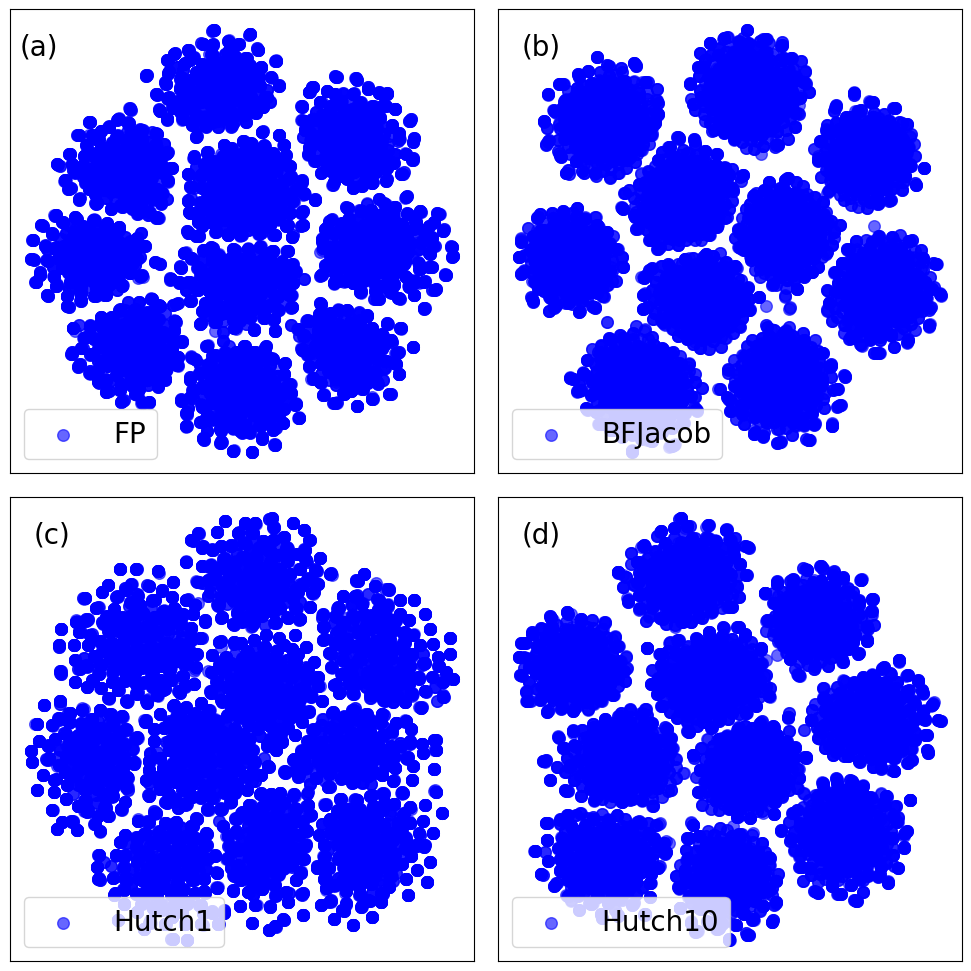

In [55]:

X_tsne_init = tsne.fit_transform(Y_init)
X_tsne_J = tsne.fit_transform(Y_J)
X_tsne_u = tsne.fit_transform(Y_FP)
X_tsne_one = tsne.fit_transform(Y_H1)
X_tsne_ten = tsne.fit_transform(Y_H10)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(X_tsne_u[:, 0], X_tsne_u[:, 1],  color='blue', s=70, alpha=0.6, label='FP')
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])
axs[0, 0].legend(loc='lower left', bbox_to_anchor=(0, 0), fontsize=20)

axs[0, 1].scatter(X_tsne_J[:, 0], X_tsne_J[:, 1],  color='blue', s=70, alpha=0.6, label='BFJacob')
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].legend(loc='lower left', bbox_to_anchor=(0, 0), fontsize=20)
axs[1, 0].scatter(X_tsne_one[:, 0], X_tsne_one[:, 1],  color='blue', s=70, alpha=0.6, label='Hutch1')
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])
axs[1, 0].legend(loc='lower left', bbox_to_anchor=(0, 0), fontsize=20)
axs[1, 1].scatter(X_tsne_ten[:, 0], X_tsne_ten[:, 1],  color='blue', s=70, alpha=0.6, label='Hutch10')
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])
axs[1, 1].legend(loc='lower left', bbox_to_anchor=(0, 0), fontsize=20)
axs[0, 0].text(0.02, 0.95, '(a)', horizontalalignment='left', verticalalignment='top', transform=axs[0, 0].transAxes, fontsize=20)
axs[0, 1].text(0.05, 0.95, '(b)', horizontalalignment='left', verticalalignment='top', transform=axs[0, 1].transAxes, fontsize=20)
axs[1, 0].text(0.05, 0.95, '(c)', horizontalalignment='left', verticalalignment='top', transform=axs[1, 0].transAxes, fontsize=20)
axs[1, 1].text(0.05, 0.95, '(d)', horizontalalignment='left', verticalalignment='top', transform=axs[1, 1].transAxes, fontsize=20)
plt.tight_layout()
plt.savefig('figures/1000-tsne.png', bbox_inches='tight')

In [56]:
ux = get_energy_device(Y_init, Nwellinfo)
ux_J = get_energy_device(Y_J, Nwellinfo)
ux_FP = get_energy_device(Y_FP, Nwellinfo)
ux_H1 = get_energy_device(Y_H1, Nwellinfo)
ux_H10 = get_energy_device(Y_H10, Nwellinfo)

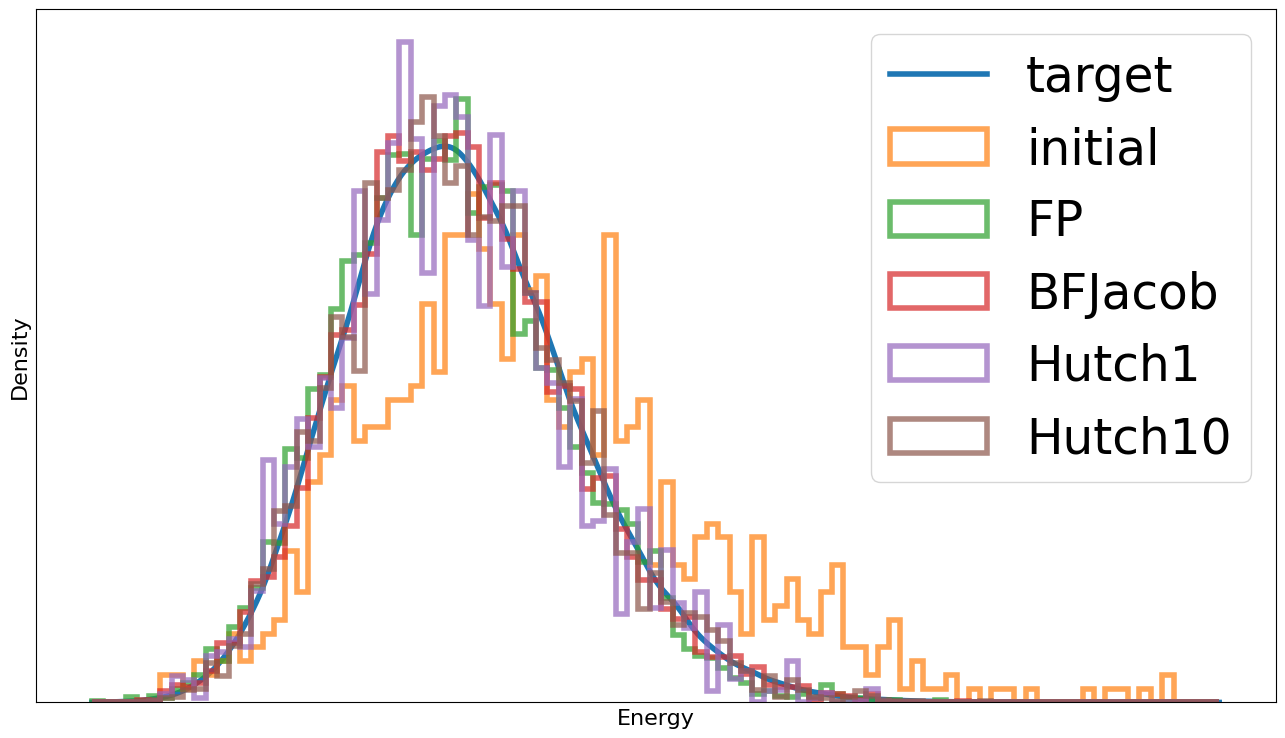

In [57]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(energy_target.cpu().numpy())
x_range = np.linspace(50, 100, 1000)
kde_values = kde(x_range)

plt.figure(figsize=(16, 9))

plt.plot(x_range, kde_values, label='target', linewidth=4)

plt.hist(ux.cpu().numpy(), alpha=0.7, bins=np.linspace(50, 100, 100), label='initial', density=True, histtype='step', linewidth=4)
plt.hist(ux_FP.cpu().numpy(), alpha=0.7, bins=np.linspace(50, 100, 100), label='FP', density=True, histtype='step', linewidth=4)
plt.hist(ux_J.cpu().numpy(), alpha=0.7, bins=np.linspace(50, 100, 100), label='BFJacob', density=True, histtype='step', linewidth=4)
plt.hist(ux_H1.cpu().numpy(), alpha=0.7, bins=np.linspace(50, 100, 100), label='Hutch1', density=True, histtype='step', linewidth=4)
plt.hist(ux_H10.cpu().numpy(), alpha=0.7, bins=np.linspace(50, 100, 100), label='Hutch10', density=True, histtype='step', linewidth=4)
plt.legend(fontsize=35)
plt.xlabel("Energy")
plt.ylabel("Density")

plt.xticks([])
plt.yticks([])
plt.savefig('figures/different_methods1000-kde.png', bbox_inches='tight')
plt.show()

In [58]:
path = 'models/GMM50/data_GMM50/GMM50'

In [59]:
energy_FP = torch.load(f'{path}-FP-energy-{back_coeff}-{K_x}-{K_eps}.pt')
energy_J = torch.load(f'{path}-J-energy-{back_coeff}-{K_x}-{K_eps}.pt')
energy_H1 = torch.load(f'{path}-H1-energy-{back_coeff}-{K_x}-{K_eps}.pt')
energy_H10 = torch.load(f'{path}-H10-energy-{back_coeff}-{K_x}-{K_eps}.pt')

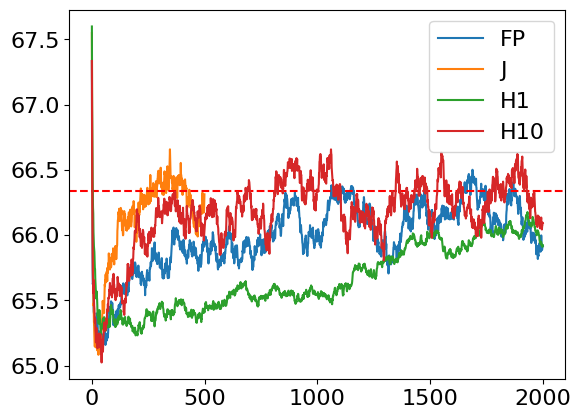

In [60]:
plt.plot(energy_FP, label='FP')
plt.plot(energy_J, label='J')
plt.axhline(y=energy_target.mean().cpu(), color='r', linestyle='--')
plt.plot(energy_H1, label='H1')
plt.plot(energy_H10, label='H10')
#plt.xlim(0, 10000)
plt.legend()